## LSTM

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords

# Load dataset
file_path = "Twitter_Data.csv"
df = pd.read_csv(file_path)

# Ensure required columns exist
if 'tweets' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must have 'text' and 'sentiment' columns.")

texts = df['tweets'].astype(str).values
labels = df['label'].values

# Preprocessing function: Remove special characters, stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

texts = [clean_text(text) for text in texts]

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Adjust parameters
max_words = 20000  # Increase vocabulary
max_len = 150  # Increase sequence length
embedding_dim = 128

# Tokenization and padding
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Adjust loss function based on label count
loss_fn = 'binary_crossentropy' if len(set(labels)) == 2 else 'sparse_categorical_crossentropy'

# Improved LSTM model
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(set(labels)), activation='softmax' if len(set(labels)) > 2 else 'sigmoid')  # Adjust for multi-class
])

model.compile(loss=loss_fn, optimizer='adam', metrics=['accuracy'])

# Train the model (increase epochs)
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 66s 29ms/step - accuracy: 0.4366 - loss: 1.0638 - val_accuracy: 0.4462 - val_loss: 1.0590
Epoch 2/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accuracy: 0.4432 - loss: 1.0588 - val_accuracy: 0.4462 - val_loss: 1.0591
Epoch 3/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 58s 28ms/step - accuracy: 0.4431 - loss: 1.0601 - val_accuracy: 0.4462 - val_loss: 1.0587
Epoch 4/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - accuracy: 0.4415 - loss: 1.0606 - val_accuracy: 0.4462 - val_loss: 1.0586
Epoch 5/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - accuracy: 0.4418 - loss: 1.0603 - val_accuracy: 0.4462 - val_loss: 1.0587
Epoch 6/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - accuracy: 0.4440 - loss: 1.0595 - val_accuracy: 0.4462 - val_loss: 1.0588
Epoch 7/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 85s 30ms/step - accuracy: 0.4441 - loss: 1.0592 - val_accuracy: 0.4462 - val_loss: 1.0586
Epoch 8/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 79s 29ms/step - accuracy: 0.4424 -

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step


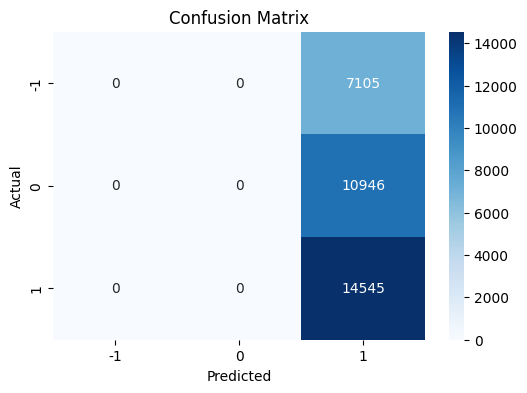

In [7]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'model' is the trained LSTM model from the previous cell
y_pred = model.predict(X_test)
# For multi-class classification, convert predictions to class labels
y_pred = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Getting pickle files

In [8]:
import pickle

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save the trained model in HDF5 format for Keras models (not .pkl, but the typical format for Keras models)
model.save('lstm_model.h5')

print("Tokenizer, label encoder, and model have been saved successfully.")


Tokenizer, label encoder, and model have been saved successfully.


## Testing tweets.csv

In [11]:
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the preprocessed tweets
file_path = "preprocessed_tweets.csv"
df_new = pd.read_csv(file_path)

# Assuming the column containing the tweets is named "tweets"
text_column = "cleaned_text"

# Load the tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load the label encoder
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Load the LSTM model
model = tf.keras.models.load_model("lstm_model.h5")

# Preprocess the new tweets
sequences = tokenizer.texts_to_sequences(df_new[text_column].astype(str).values)
padded_sequences = pad_sequences(sequences, maxlen=model.input_shape[1], padding='post') # Use model's input shape for padding length

# Make predictions
predictions = model.predict(padded_sequences)

# For multi-class classification, convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Decode predicted labels back to original labels if needed
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# Add predictions as a new column
df_new["sentiments"] = decoded_predictions

# Save the updated DataFrame to a new CSV file
output_path = "predicted_tweets_lstm.csv"
df_new.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")
print(df_new.head())

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Predictions saved to predicted_tweets_lstm.csv
                                                Text  \
0  Excited to have Larry Ellison &amp; Kathleen W...   
1  When one of the interns working on the simulat...   
2                           @5AllanLeVito Got it 😀🇺🇦   
3  Yes. Supercharger coverage will extend to 100%...   
4                     @demishassabis Congratulations   

                                        cleaned_text  sentiments  
0  excited larry ellison amp kathleen wilsonthomp...           1  
1          one interns working simulation drops ball           1  
2                                                got           1  
3  yes supercharger coverage extend europe next y...           1  
4                                    congratulations           1  
